In [462]:
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as si
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import backtest
import random
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
import seaborn as sns
from sklearn import linear_model

## Input & factor

In [463]:
XAU_USD = pd.read_csv('NYU_XAU_USD_20142015_Fall2019.csv')
XAU_USD.Date = pd.to_datetime(XAU_USD.Date)

USD_JPY = pd.read_csv('NYU_USD_JPY_2016_Fall2019 .csv')
USD_JPY.Date = pd.to_datetime(USD_JPY.Date)

In [464]:
def df_prepare(df):
    new_df = df.copy()
    new_df["Return"] = new_df["Price"].diff()/new_df["Price"]

    # adj flow is L/S in range(0,1)
    new_df["adj_flow"] = new_df["Flow"]
    new_df["adj_flow"][new_df["adj_flow"]<=0] = -1/new_df["adj_flow"][new_df["adj_flow"]<=0]
    #new_df = new_df.set_index("Date")
    return new_df

clean_USD_JPY = df_prepare(USD_JPY).dropna()
clean_XAU_USD = df_prepare(XAU_USD).dropna()

class Factors():  
    def __init__(self, df):
        self.price_flow= df     
    # SMA: rolling mean
    def MA_price(self, periods):
        MA_price = self.price_flow['Price'].rolling(window=periods).mean() 
        #return MA_price
        return MA_price.shift()
    def MA_flow(self, periods):
        MA_flow = self.price_flow['Flow'].rolling(window=periods).mean()
    def MA_adj_flow(self, periods):
        MA_flow = self.price_flow['adj_flow'].rolling(window=periods).mean() 
        #return MA_flow
        return MA_flow.shift()
    # Var: rolling std of price
    def Var_price(self, periods): #periods is the # of hours
        Var_price = self.price_flow['Price'].rolling(window=periods).std() 
        #return Var_price
        return Var_price.shift()
    def Var_flow(self, periods):
        Var_flow = self.price_flow['adj_flow'].rolling(window=periods).std() 
        #return Var_flow
        return Var_flow.shift()
    # High Low rolling
    def High_flow(self, periods):
        High_flow = self.price_flow['adj_flow'].rolling(window=periods).max()
        return High_flow.shift()
    def Low_flow(self, periods):
        Low_flow = self.price_flow['adj_flow'].rolling(window=periods).min()
        return Low_flow.shift()
    def calculat_High_price(self, periods):
        self.High_price = self.price_flow['Price'].rolling(window=periods).max()
        return self.High_price
    def calculat_Low_price(self, periods):
        self.Low_price = self.price_flow['Price'].rolling(window=periods).min()
        return self.Low_price

    def moving_range(self, periods_minmax, period_range):
        range_high = self.calculat_High_price(periods_minmax).rolling(window=period_range).max().shift()
        range_low = self.calculat_Low_price(periods_minmax).rolling(window=period_range).max().shift( )
        return list(zip(range_low,range_high))
   
    # Corr of price and flow
    def corr_p_f(self, periods):
        corr_p_f = clean_USD_JPY[["Flow","Price"]].rolling(6).corr().loc[pd.IndexSlice[:,"Flow"],"Price"].reset_index().set_index("level_0")["Price"]
        return corr_p_f
    
    # Exponentially-weighted moving average 
    def EWMA_price(self, periods):
        EWMA_price = self.price_flow['Price'].ewm(span=periods).mean()
        return EWMA_price
    
    def EWMA_flow(self, periods):
        EWMA_flow = self.price_flow['adj_flow'].ewm(span=periods).mean()
        return EWMA_flow 
    
    # RSI: Relative strength index (ratio of up-moves to down-moves)
    def RSI(self, periods):
        delta = self.price_flow['Price'].copy().diff()
        up, down = delta.copy(), delta.copy()
        up[up < 0] = 0
        down[down > 0] = 0

        # Calculate the SMA
        roll_up = up.rolling(periods).mean()
        roll_down = down.rolling(periods).mean()*(-1)
        # Calculate the RSI based on SMA
        RSI = roll_up /(roll_up + roll_down)*100
        #RSI = 100.0 - (100.0 / (1.0 + RS))
        return RSI.shift()

## backtest

In [465]:
def calculate_backtest_return(BO_spread,TTE,signal,data):
    backtest = pd.concat([data,signal],axis = 1).dropna()
    backtest['Price_pre'] = backtest['Price'].shift()
    backtest['signal_pre'] = backtest['signal'].shift()
    backtest['signal_pre_pre'] = backtest['signal_pre'].shift()
    backtest.dropna(inplace = True)
    backtest['return'] = ((backtest['Price'] - backtest['Price_pre'])/backtest['Price_pre'])*backtest['signal_pre']-np.abs(backtest['signal_pre']-backtest['signal_pre_pre'])*BO_spread/2/backtest['Price_pre']
    return backtest['return']

class backtesting():
    def __init__(self,BO_spread,TTE,signal,data,r_f=0):
        self.r_f = r_f
        self.BO_spread = BO_spread
        self.TTE = TTE
        self.signal = signal
        self.data = data
        self.ret = calculate_backtest_return(BO_spread,TTE,signal,data)
        self.daily_return = self.ret.copy()
        self.daily_return.index = self.daily_return.index.date
        self.daily_return = self.daily_return.groupby(self.daily_return.index).sum()
        self.daily_std = np.std(self.daily_return)
        self.IR = np.mean(self.daily_return/self.daily_std)
    def plot_accumulate_return(self):
        self.daily_return.cumsum().plot()

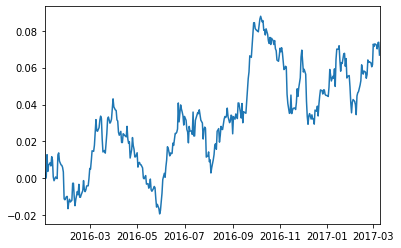

In [466]:
#JPY['Date']=pd.to_datetime(JPY['Date'])
#JPY.set_index(['Date'],inplace=True)

USD_JPY_COPY = USD_JPY.copy()
USD_JPY_COPY .set_index(['Date'],inplace = True)
length = len(USD_JPY_COPY)
## test the backtesting:
random_sig =pd.Series(data = [random.randint(-1,1) for i in range(length)],name = 'signal')
random_sig.index = USD_JPY_COPY.index
a = backtesting(0,0,random_sig,USD_JPY_COPY,r_f=0)
a.plot_accumulate_return()

# alpha machine

# LSTM

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Train on 5901 samples, validate on 1478 samples
Epoch 1/20
5901/5901 [==============================] - 6s 1ms/sample - loss: 0.7888 - val_loss: 0.6958
Epoch 2/20
5901/5901 [==============================] - 2s 351us/sample - loss: 0.6971 - val_loss: 0.6948
Epoch 3/20
5901/5901 [==============================] - 2s 344us/sample - loss: 0.6963 - val_loss: 0.6943
Epoch 4/20
5901/5901 [==============================] - 2s 318us/sample - loss: 0.6947 - val_loss: 0.6937
Epoch 5/20
5901/5901 [==============================] - 2s 336us/sample - loss: 0.6956 - val_loss: 0.6947
Epoch 6/20
5901/5901 [==============================] - 2s 356us/sample - loss: 0.6943 - val_loss: 0.6941
Epoch 7/20
5901/5901 [==============================] - 2s 348us/sample - loss: 0.6943 - val_loss: 0.6943
Epoch 8/20
5901/5901 [==============================] - 2s 316us/sample - loss: 0.6942 - val_loss: 0.7002
Epoch 9/20
5901/5901 [================

,true_prob,signal
Date,,
2016-12-13 06:00:00,0.506903,1
2016-12-13 07:00:00,0.506574,1
2016-12-13 08:00:00,0.505489,1
2016-12-13 09:00:00,0.505514,1
2016-12-13 10:00:00,0.505756,1
2016-12-13 11:00:00,0.505427,1
2016-12-13 12:00:00,0.504825,0
2016-12-13 13:00:00,0.504452,0
2016-12-13 14:00:00,0.504062,0


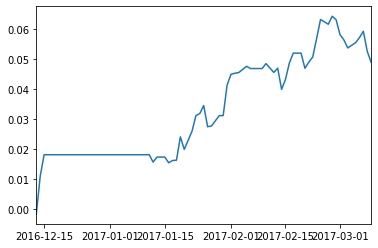

In [467]:
def run_LSTM(df_input,train_split):
    #JPY = pd.read_csv('NYU_USD_JPY_2016_Fall2019 .csv')
    JPY = df_input
    JPY['Date']=pd.to_datetime(JPY['Date'])
    JPY.set_index(['Date'],inplace=True)

    for i in range(12):
        JPY['Price_lag'+str(i)] = JPY['Price'].shift(i)
        JPY['Flow_lag'+str(i)] = JPY['Flow'].shift(i)

    JPY['y'] = (JPY['Price'].shift(-1)-JPY['Price'])>0 
    
    train_len = int(len(JPY)*train_split)
    test_len = int(len(JPY)) - train_len

    train = JPY.iloc[:int(len(JPY)*4/5)]
    test = JPY.iloc[int(len(JPY)*4/5):int(len(JPY)*5/5)]
    y_train = train.dropna()['y'].values
    X_train = train.dropna().loc[:,'Price':'Flow_lag11'].values
    y_test = test['y'].values
    X_test = test.loc[:,'Price':'Flow_lag11'].dropna().values
                                    
    X_train = X_train.reshape(X_train.shape[0],13,2)
    X_test = X_test.reshape(X_test.shape[0],13,2)
    y_train = y_train.reshape(X_train.shape[0],1)
    y_test = y_test.reshape(X_test.shape[0],1)

    try:
        # %tensorflow_version only exists in Colab.
        %tensorflow_version 2.x
        IS_COLAB = True
    except Exception:
        IS_COLAB = False

    if not tf.test.is_gpu_available():
        print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
        if IS_COLAB:
            print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

    np.random.seed(42)
    tf.random.set_seed(42)

    model = keras.models.Sequential([
        keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 2]),
        keras.layers.Dense(1)
    ])

    model.compile(loss="binary_crossentropy", optimizer="adam")
    history = model.fit(X_train, y_train, epochs=20,
                        validation_data=(X_test, y_test))

    y_predict = model.predict(X_test)[:,-1,:]
    std = np.std(model.predict(X_train)[:,-1,:])
    result = pd.DataFrame(y_predict,index = test.index,columns = ['true_prob'])

    def cal_signal(x):
        if x>0.5+std:
            return 1
        elif x<0.5-std:
            return -1
        else:
            return 0
    
    result['signal'] = result['true_prob'].apply(cal_signal)
    result['signal'].value_counts()

    a = backtesting(0,0,result['signal'],JPY,r_f=0)
    a.plot_accumulate_return()
    return result
    
run_LSTM(pd.read_csv('NYU_USD_JPY_2016_Fall2019 .csv'),0.8)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Train on 9798 samples, validate on 2453 samples
Epoch 1/10
9798/9798 [==============================] - 6s 659us/sample - loss: 0.6934 - val_loss: 0.6924
Epoch 2/10
9798/9798 [==============================] - 3s 298us/sample - loss: 0.6930 - val_loss: 0.6921
Epoch 3/10
9798/9798 [==============================] - 3s 295us/sample - loss: 0.6927 - val_loss: 0.6920
Epoch 4/10
9798/9798 [==============================] - 3s 333us/sample - loss: 0.6926 - val_loss: 0.6919
Epoch 5/10
9798/9798 [==============================] - 3s 334us/sample - loss: 0.6925 - val_loss: 0.6919
Epoch 6/10
9798/9798 [==============================] - 3s 333us/sample - loss: 0.6925 - val_loss: 0.6919
Epoch 7/10
9798/9798 [==============================] - 4s 381us/sample - loss: 0.6924 - val_loss: 0.6919
Epoch 8/10
9798/9798 [==============================] - 3s 319us/sample - loss: 0.6924 - val_loss: 0.6919
Epoch 9/10
9798/9798 [==============

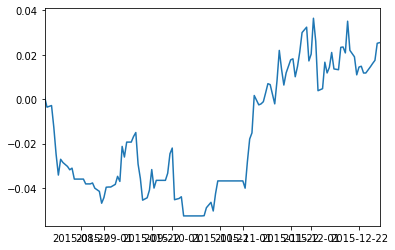

In [468]:

JPY = pd.read_csv('NYU_XAU_USD_20142015_Fall2019.csv')
JPY['Date']=pd.to_datetime(JPY['Date'])
JPY.set_index(['Date'],inplace=True)

JPY['Return'] = (JPY['Price']-JPY['Price'].shift())/JPY['Price'].shift()
JPY.dropna(inplace=True)

for i in range(12):
    JPY['Flow_lag'+str(i)] = JPY['Flow'].shift(i)
    JPY['Return_lag'+str(i)] = JPY['Return'].shift(i)
    
JPY['y'] = JPY['Return'].shift(-1)>0 

train = JPY.iloc[:int(len(JPY)*4/5)]
test = JPY.iloc[int(len(JPY)*4/5):int(len(JPY)*5/5)]
y_train = train.dropna()['y'].values
X_train = train.dropna().loc[:,'Flow':'Return_lag11'].values
y_test = test['y'].values
X_test = test.loc[:,'Flow':'Return_lag11'].dropna().values

X_train = X_train.reshape(X_train.shape[0],13,2)
X_test = X_test.reshape(X_test.shape[0],13,2)
y_train = y_train.reshape(X_train.shape[0],1)
y_test = y_test.reshape(X_test.shape[0],1)

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False
    
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
        
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=False, input_shape=[None, 2]),
    keras.layers.Dense(1,activation='sigmoid')
])
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss="binary_crossentropy", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_test, y_test))

y_predict = model.predict(X_test)
y_predict.max()
std = model.predict(X_train).std()
def cal_signal(x):
    if x>0.5+std:
        return 1
    elif x<0.5-std:
        return -1
    else:
        return 0

result = pd.DataFrame(y_predict,index = test.index,columns = ['true_prob'])
result['signal'] = result['true_prob'].apply(cal_signal)

a = backtesting(0,0,result['signal'],JPY,r_f=0)
a.plot_accumulate_return()

# pseudoscience

## factor prepare

In [469]:
def df_prepare(df):
    new_df = df.copy()
    new_df["Return"] = new_df["Price"].diff()/new_df["Price"]

    # adj flow is L/S in range(0,1)
    new_df["adj_flow"] = new_df["Flow"]
    new_df["adj_flow"][new_df["adj_flow"]<=0] = -1/new_df["adj_flow"][new_df["adj_flow"]<=0]
    #new_df = new_df.set_index("Date")
    return new_df

clean_USD_JPY = df_prepare(USD_JPY).dropna()
clean_XAU_USD = df_prepare(XAU_USD).dropna()

class Factors():  
    def __init__(self, df):
        self.price_flow= df     
    # SMA: rolling mean
    
    def MA_price(self, periods):
        MA_price = self.price_flow['Price'].rolling(window=periods).mean() 
        #return MA_price
        return MA_price.shift()
    
    def MA_flow(self, periods):
        MA_flow = self.price_flow['Flow'].rolling(window=periods).mean()
        return MA_flow.shift()
    
    def _2xMA_price(self, periods):
        MA_flow = self.price_flow['Price'].rolling(window=2*periods).mean()
        return MA_flow.shift()
    
    def MA_adj_flow(self, periods):
        MA_flow = self.price_flow['adj_flow'].rolling(window=periods).mean() 
        #return MA_flow
        return MA_flow.shift()
    
    # Var: rolling std of price
    def Var_price(self, periods): #periods is the # of hours
        Var_price = self.price_flow['Price'].rolling(window=periods).std() 
        #return Var_price
        return Var_price.shift()
    
    def MA_var_price(self,periods):
        ma_Var_price = self.price_flow['Price'].rolling(window=periods).std().rolling(window=periods).mean() 
        #return Var_price
        return ma_Var_price.shift()
    
    def Var_var_price(self,periods):
        Var_Var_price = self.price_flow['Price'].rolling(window=periods).std().rolling(window=periods).std() 
        #return Var_price
        return Var_Var_price.shift()
    
    def Var_flow(self, periods):
        Var_flow = self.price_flow['adj_flow'].rolling(window=periods).std() 
        #return Var_flow
        return Var_flow.shift()
    
    # High Low rolling
    def High_flow(self, periods):
        High_flow = self.price_flow['adj_flow'].rolling(window=periods).max()
        return High_flow.shift()
    
    def Low_flow(self, periods):
        Low_flow = self.price_flow['adj_flow'].rolling(window=periods).min()
        return Low_flow.shift()
    
    def calculat_High_price(self, periods):
        self.High_price = self.price_flow['Price'].rolling(window=periods).max()
        return self.High_price
    
    def calculat_Low_price(self, periods):
        self.Low_price = self.price_flow['Price'].rolling(window=periods).min()
        return self.Low_price

    def moving_range(self, periods_minmax, period_range):
        range_high = self.calculat_High_price(periods_minmax).rolling(window=period_range).max().shift()
        range_low = self.calculat_Low_price(periods_minmax).rolling(window=period_range).max().shift( )
        return list(zip(range_low,range_high))
   
    # Corr of price and flow
    def corr_p_f(self, periods):
        corr_p_f = clean_USD_JPY[["Flow","Price"]].rolling(6).corr().loc[pd.IndexSlice[:,"Flow"],"Price"].reset_index().set_index("level_0")["Price"]
        return corr_p_f
    
    # Exponentially-weighted moving average 
    def EWMA_price(self, periods):
        EWMA_price = self.price_flow['Price'].ewm(span=periods).mean()
        return EWMA_price
    
    def EWMA_flow(self, periods):
        EWMA_flow = self.price_flow['adj_flow'].ewm(span=periods).mean()
        return EWMA_flow 
    
    # RSI: Relative strength index (ratio of up-moves to down-moves)
    def RSI(self, periods):
        delta = self.price_flow['Price'].copy().diff()
        up, down = delta.copy(), delta.copy()
        up[up < 0] = 0
        down[down > 0] = 0

        # Calculate the SMA
        roll_up = up.rolling(periods).mean()
        roll_down = down.rolling(periods).mean()*(-1)
        # Calculate the RSI based on SMA
        RSI = roll_up /(roll_up + roll_down)*100
        #RSI = 100.0 - (100.0 / (1.0 + RS))
        return RSI.shift()

In [470]:
def prepare_factors(clean_input,period): 
    UJ_class = Factors(clean_input)
    Factor_USD_ = clean_input.copy()
    Factor_USD_["MA_price_long"] = UJ_class.MA_price(5*4*period)
    Factor_USD_["MA_price_short"] = UJ_class.MA_price(2*4*period)
    Factor_USD_["MA_flow"] = UJ_class.MA_flow(period)
    Factor_USD_["_2xMA_price"] = UJ_class.MA_flow(period)
    Factor_USD_["Var_price"] = UJ_class.Var_price(period)
    Factor_USD_["MA_var_price"] = UJ_class.MA_var_price(period)
    Factor_USD_["Var_var_price"] = UJ_class.Var_var_price(period)
    Factor_USD_["Var_flow"] = UJ_class.Var_flow(period)
    Factor_USD_["High_flow"] = UJ_class.High_flow(period)
    Factor_USD_["Low_flow"] = UJ_class.Low_flow(period)
    Factor_USD_["High_price"] = UJ_class.calculat_High_price(period)
    Factor_USD_["Low_price"] = UJ_class.calculat_Low_price(period)
    Factor_USD_["EWMA_price"] = UJ_class.EWMA_price(period)
    Factor_USD_["EWMA_flow"] = UJ_class.EWMA_flow(period)
    Factor_USD_["corr_p_f"] = UJ_class.corr_p_f(period)
    Factor_USD_["RSI"] = UJ_class.RSI(period)
    Factor_USD_["DD"] = Factor_USD_["Price"] - UJ_class.calculat_High_price(period)
    Factor_USD_["Moving_range"] = UJ_class.moving_range(period,6*period)
    return Factor_USD_

Factor_USD_JPY = prepare_factors(clean_USD_JPY,6)
Factor_XAU_USD = prepare_factors(clean_XAU_USD,6)

Factor_USD_JPY.to_csv('factor_jpy.csv')
Factor_XAU_USD.to_csv('factor_xau.csv')

df_input = Factor_USD_JPY.dropna(axis=0).reset_index()

In [530]:
df_input = Factor_XAU_USD.dropna(axis=0).reset_index()

In [ ]:
Factor_XAU_USD.

## alpha engine

In [531]:
def mr_regime(df_,parameters=0,weights=[1,1,1]):
    regime_mr = True 
    #for below votes: if MR, then 1
    #1 no large order/imbanlence vol 
    vote_volu_range=[]
    for i in range(len( df_input.adj_flow)):
        if (( df_input.Flow[i] > df_input.MA_flow[i]+0.8*df_input.Var_flow[i]) or (df_input.Flow[i] < df_input.MA_flow[i]-0.8*df_input.Var_flow[i])):
            vote_volu_range.append(0)
        else:
            vote_volu_range.append(1)
    #2 Price moving out of range/DD?  --- 1:mr
    vote_price_range = []
    range_table = [ list(t) for t in (df_.Moving_range) ]
    for i in range(len(df_.Moving_range)):
        if df_.Price[i]<range_table[i][0] or df_.Price[i]>range_table[i][1]:
            vote_price_range.append(0)
        else:
            vote_price_range.append(1)       
    #3 tech signal (rsi) and death cross
    rsi = []
    for i in range(len(df_.RSI)):
        if df_.RSI[i]<60 or df_.Price[i]>40:
            rsi.append(1)
        else:
            rsi.append(0)
    # 这个放到后面
    #3 DD
    #4 volatility
    vote_vola_range=[]
    for i in range(len( df_.Var_price)):
        if (( df_.Var_price[i] > df_.MA_var_price[i]+0.1*df_.Var_var_price[i]) or (df_.Var_price[i] < df_.Var_price[i]-0.1*df_.Var_var_price[i])):
            vote_vola_range.append(0)
        else:
            vote_vola_range.append(1)
    result = [vote_volu_range[i] + vote_price_range[i] + vote_vola_range[i]+rsi[i] for i in range(len(vote_volu_range))]
    return result

In [539]:
state_weight

[2,
 2,
 3,
 3,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 3,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 2,
 1,
 2,
 1,
 2,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 1,
 2,
 2,
 1,
 1,
 3,
 3,
 4,
 4,
 3,
 2,
 2,
 2,
 1,
 2,
 2,
 3,
 3,
 3,
 2,
 2,
 1,
 1,
 1,
 3,
 2,
 2,
 3,
 3,
 2,
 3,
 2,
 2,
 3,
 3,
 2,
 2,
 2,
 2,
 1,
 1,
 3,
 4,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 3,
 3,
 1,
 1,
 2,
 1,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 1,
 3,
 3,
 1,
 1,
 1,
 1,
 2,
 2,
 3,
 1,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 3,
 4,
 4,
 3,
 3,
 2,
 3,
 3,
 4,
 4,
 3,
 3,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 3,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 3,
 2,
 2,
 3,
 3,
 2,
 2,
 1,
 2,
 3,
 4,
 4,
 3,
 3,
 1,
 2,
 1,
 1,
 3,
 3,
 4,
 4,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 4,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 3,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 3,
 3,
 3,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 3,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 3,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 3,


In [532]:
mr_state = []
state_weight = mr_regime(df_input,0)
for i in range(len(mr_regime(df_input,0))):
    p = state_weight[i]
    if p <= 2:
        mr_state.append(False)
    if p > 2:
        mr_state.append(True)

In [533]:
def mr_strategy(df_,state_list,weight=[0.5,0.5]):
    signal = []
    sig_p,sig_r = [],[]
    for i in range(len(df_.Price)-1):
        if not (state_list[i] and state_list[i+1]) :
            signal.append(0)
        else:
            #1 MA standard 0.8
            if df_.Price[i] < df_._2xMA_price[i]-0.42*df_.Var_price[i]:
                fuzzy_grade_p = -1
            elif df_.Price[i] > df_._2xMA_price[i]+0.42*df_.Var_price[i]:
                fuzzy_grade_p = 1
            else:
                fuzzy_grade_p = 0
            '''
            #2 RSI statdard 0.2
            if df_.RSI[i]<10:
                fuzzy_grade_r = 2 
            elif df_.RSI[i]<25:
                fuzzy_grade_r = 1 
            elif df_.RSI[i]>90:
                fuzzy_grade_r = -2 
            elif df_.RSI[i]>80:
                fuzzy_grade_r = -1
            else:
                fuzzy_grade_r = 0
            '''
            if df_.RSI[i]<10:
                fuzzy_grade_r = -1
            elif df_.RSI[i]>90:
                fuzzy_grade_r = 1
            else: fuzzy_grade_r = 0
            #signal.append(fuzzy_grade_p*weight[0]+fuzzy_grade_r*weight[0])
            sig_p.append(fuzzy_grade_p)
            sig_r.append(fuzzy_grade_r)
    for i in range(len(sig_p)):
        signal.append(sig_p[i])
    signal.append(0)
    return signal

In [534]:
my_stra = mr_strategy(df_input,mr_state)

In [535]:
sum(my_stra)

1136

In [536]:
'''
trend_stra = []
for i in range(len(my_stra)):
    p = my_stra[i]
    if p <= 0:
        trend_stra.append(0)
    if p > 0:
        trend_stra.append(1)
'''

'\ntrend_stra = []\nfor i in range(len(my_stra)):\n    p = my_stra[i]\n    if p <= 0:\n        trend_stra.append(0)\n    if p > 0:\n        trend_stra.append(1)\n'

# 总结/ 画一个 return vs strategy performance

In [537]:
my_sig = []
for i in range(len(my_stra)):
    if my_stra[i]<0:
        my_sig.append(-1)
    elif my_stra[i]>0:
        my_sig.append(1)
    else:
        my_sig.append(0)

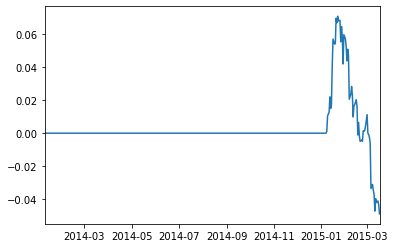

In [538]:
USD_JPY_COPY = df_input.copy()
USD_JPY_COPY.set_index(['Date'],inplace = True)
length = len(USD_JPY_COPY)
## test the backtesting:
random_sig = pd.Series(data = my_sig,name = 'signal')
random_sig.index= USD_JPY_COPY.index
a = backtesting(0,0,random_sig,USD_JPY_COPY,r_f=0)
a.plot_accumulate_return()

In [374]:
df_input['mr_state'] = mr_state
df_input['my_sig'] = my_sig
df_input['my_stra'] = my_stra
#fig = plt.figure(figsize=(20, 20))
#axes = fig.add_subplot(111)
#axes.scatter(df_input.Price[df_input['my_stra']==-1].index, df_input.Price[df_input['my_stra']==-1],color = 'blue',s=1)
#axes.scatter(df_input.Price[df_input['mr_state']==True].index, df_input.Price[df_input['mr_state']==True],color = 'red',s=10)
#axes.scatter(df_input.Price[df_input['my_sig']==1].index, df_input.Price[df_input['my_sig']==1],color = 'blue',s=100)

In [376]:
df_input.to_csv('my_strategy.csv')

In [377]:
fig = plt.figure(figsize=(20, 20))
axes = fig.add_subplot(111)
#axes.scatter(df_input.Price[df_input['mr_state']==0].index, df_input.Price[df_input['mr_state']==0],color = 'blue',s=1)
axes.scatter(df_input.Price[df_input['my_sig']==-1].index, df_input.Price[df_input['my_sig']==-1],color = 'red',s=10)
axes.scatter(df_input.Price[df_input['my_sig']==1].index, df_input.Price[df_input['my_sig']==1],color = 'blue',s=100)

,index,Ticker,Date,Price,Flow,Return,adj_flow,MA_price_long,MA_price_short,MA_flow,...,Low_price,EWMA_price,EWMA_flow,corr_p_f,RSI,DD,Moving_range,my_sig,my_stra,mr_state
0,121,USD/JPY_B,2016-01-10 18:00:00,116.814,2.460513,-0.003313,2.460513,118.640983,117.964417,2.446930,...,116.814,117.361820,2.448842,-0.585933,9.924812,-0.986,"(118.259, 118.463)",0,0,True
1,122,USD/JPY_B,2016-01-10 19:00:00,117.064,2.416254,0.002136,2.416254,118.612058,117.929729,2.457206,...,116.814,117.276729,2.439531,-0.276220,4.457364,-0.711,"(118.259, 118.463)",0,0,False
2,123,USD/JPY_B,2016-01-10 20:00:00,117.060,2.263695,-0.000034,2.263695,118.584950,117.897354,2.461615,...,116.814,117.214806,2.389292,0.163620,20.226537,-0.587,"(118.259, 118.463)",0,0,False
3,124,USD/JPY_B,2016-01-10 21:00:00,117.211,2.209429,0.001288,2.209429,118.557358,117.864646,2.436336,...,116.814,117.213719,2.337903,0.116692,20.576132,-0.281,"(118.259, 118.463)",0,0,False
4,125,USD/JPY_B,2016-01-10 22:00:00,117.257,2.122929,0.000392,2.122929,118.533883,117.850375,2.401348,...,116.814,117.226085,2.276482,-0.434153,32.390953,0.000,"(118.259, 118.463)",0,0,False
5,126,USD/JPY_B,2016-01-10 23:00:00,117.360,2.088813,0.000878,2.088813,118.512542,117.835146,2.340337,...,116.814,117.264346,2.222862,-0.923908,39.592560,0.000,"(118.259, 118.463)",0,0,False
6,127,USD/JPY_B,2016-01-11 00:00:00,117.386,2.076401,0.000221,2.076401,118.493200,117.817437,2.260272,...,117.060,117.299104,2.181016,-0.909006,58.448459,0.000,"(118.259, 118.463)",0,0,False
7,128,USD/JPY_B,2016-01-11 01:00:00,117.315,2.037221,-0.000605,2.037221,118.475117,117.805208,2.196254,...,117.060,117.303646,2.139932,-0.905232,99.310345,-0.071,"(118.259, 118.463)",0,0,False
8,129,USD/JPY_B,2016-01-11 02:00:00,117.133,1.983105,-0.001554,1.983105,118.457867,117.791896,2.133081,...,117.133,117.254890,2.095124,0.088686,81.296758,-0.253,"(118.259, 118.463)",0,0,False
9,130,USD/JPY_B,2016-01-11 03:00:00,117.316,1.884170,0.001560,1.884170,118.438758,117.773375,2.086316,...,117.133,117.272350,2.034851,0.233772,56.303972,-0.070,"(118.259, 118.463)",0,0,False


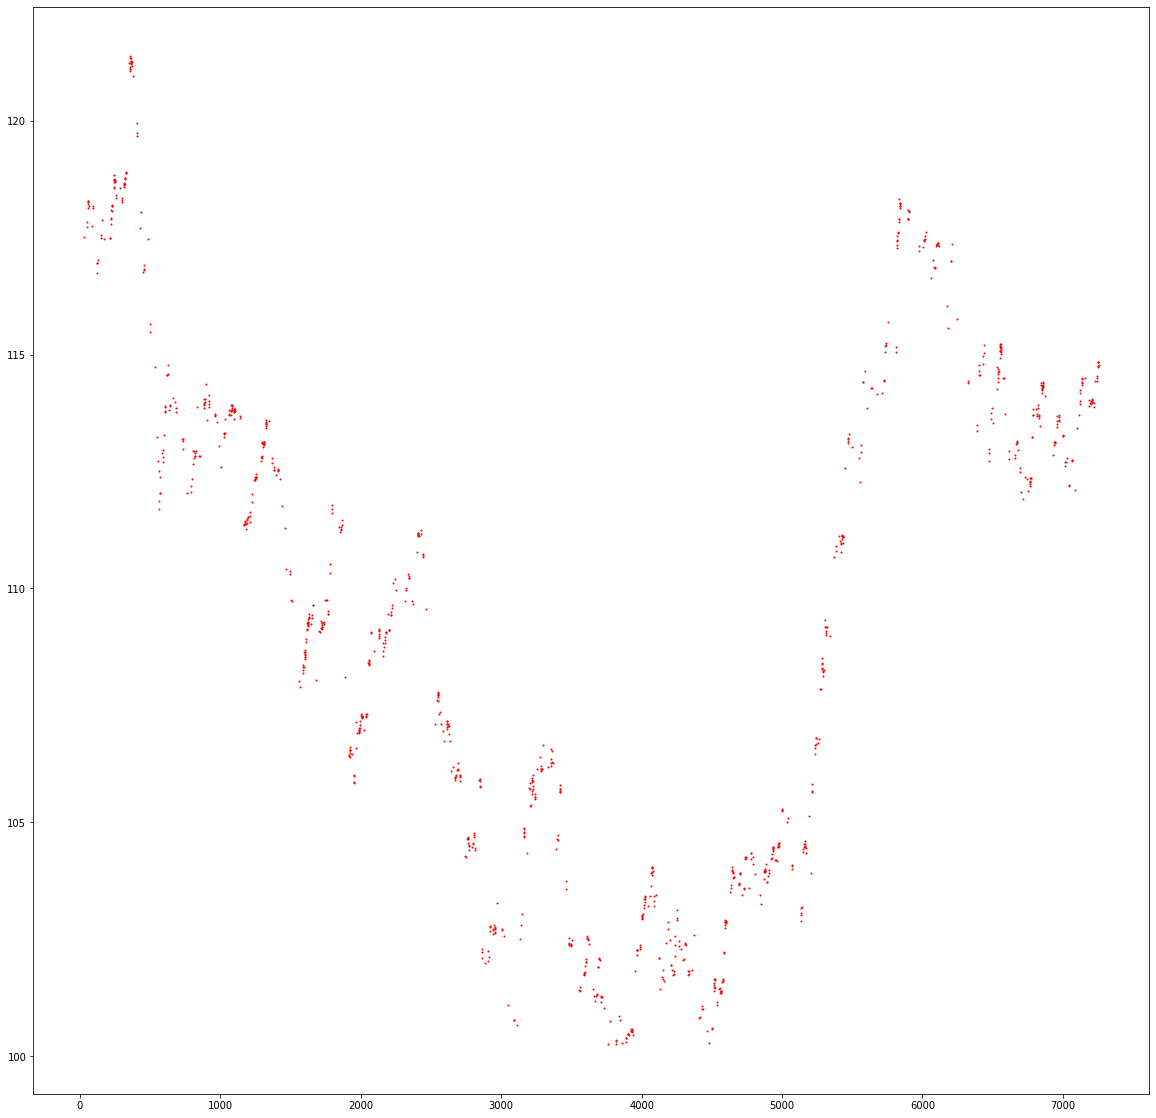

In [461]:
fig = plt.figure(figsize=(20, 20))
axes = fig.add_subplot(111)
#axes.scatter(df_input.Price[df_input['mr_state']==0].index, df_input.Price[df_input['mr_state']==0],color = 'blue',s=1)
axes.scatter(df_input.Price[df_input['my_sig']==-1].index, df_input.Price[df_input['my_sig']==-1],color = 'red',s=1)
axes.scatter(df_input.Price[df_input['my_sig']==1].index, df_input.Price[df_input['my_sig']==1],color = 'blue',s=100)

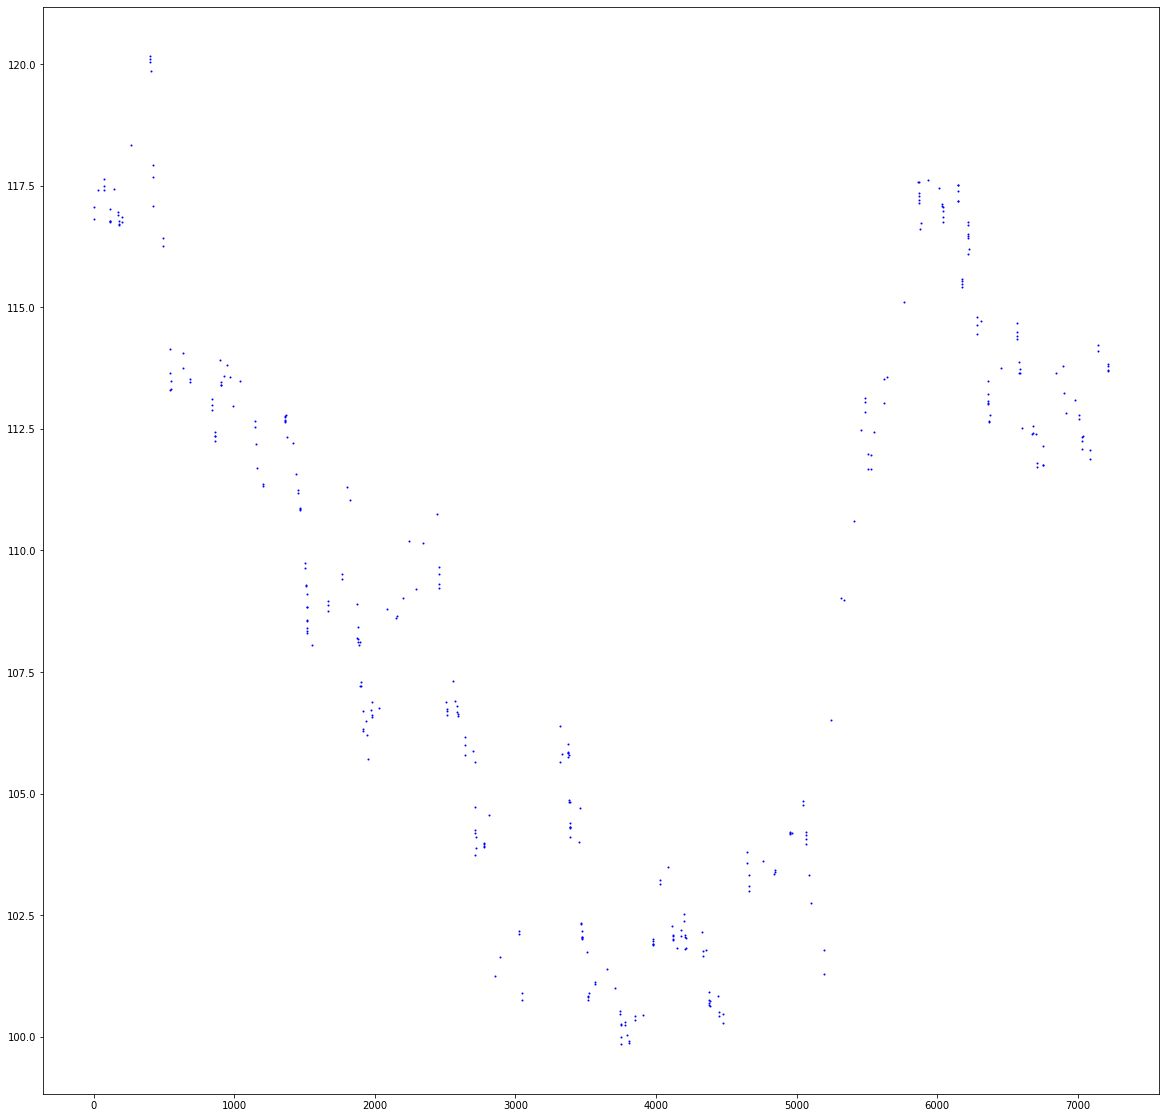

In [458]:
fig = plt.figure(figsize=(20, 20))
axes = fig.add_subplot(111)
axes.scatter(df_input.Price[df_input['RSI']<10].index, df_input.Price[df_input['RSI']<10],color = 'blue',s=1)
#axes.scatter(df_input.Price[df_input['mr_state']==0].index, df_input.Price[df_input['mr_state']==0],color = 'blue',s=1)

# real MR regime

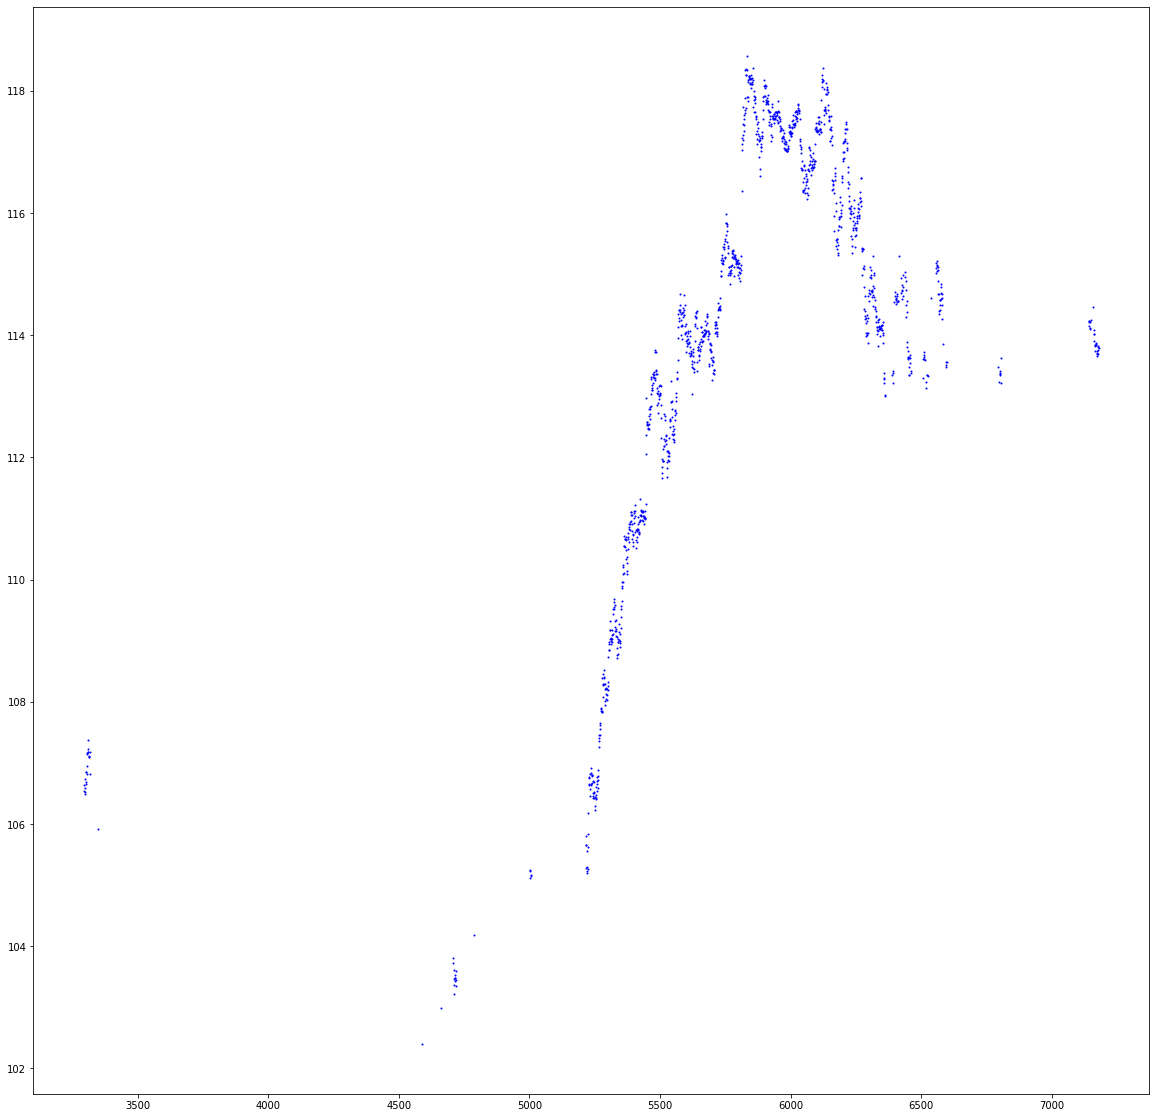

In [433]:
fig = plt.figure(figsize=(20, 20))
axes = fig.add_subplot(111)
axes.scatter(df_input.Price[df_input['adj_flow']<1.0].index, df_input.Price[df_input['adj_flow']<1.0],color = 'blue',s=1)
#axes.scatter(df_input.Price[df_input['mr_state']==0].index, df_input.Price[df_input['mr_state']==0],color = 'blue',s=1)

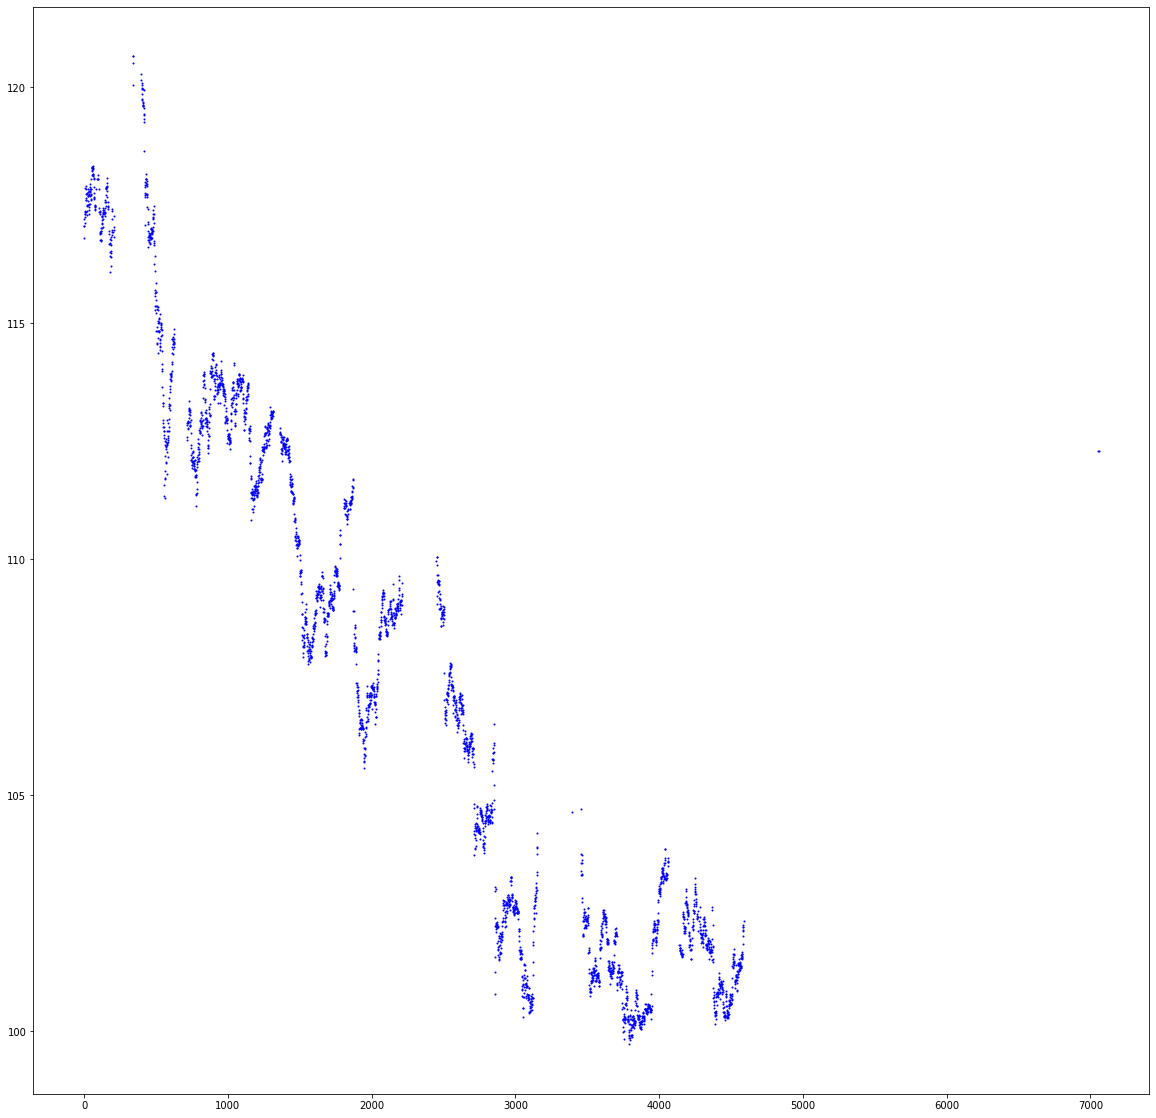

In [459]:
fig = plt.figure(figsize=(20, 20))
axes = fig.add_subplot(111)
axes.scatter(df_input.Price[df_input['Flow']>1.7].index, df_input.Price[df_input['Flow']>1.7],color = 'blue',s=1)
#axes.scatter(df_input.Price[df_input['mr_state']==0].index, df_input.Price[df_input['mr_state']==0],color = 'blue',s=1)

In [ ]:
real_df_input = Factor_USD_JPY.dropna(axis=0).reset_index()
real_df_input['real_mr_state'] = real_mr_state
real_df_input['real_my_sig'] = real_my_sig
real_df_input['real_my_stra'] = real_my_stra

# liNEAR

In [ ]:
regr = linear_model.LinearRegression()
regr.fit(df['square_feet'].reshape(-1, 1), df['price']) # 注意此处.reshape(-1, 1)，因为X是一维的！


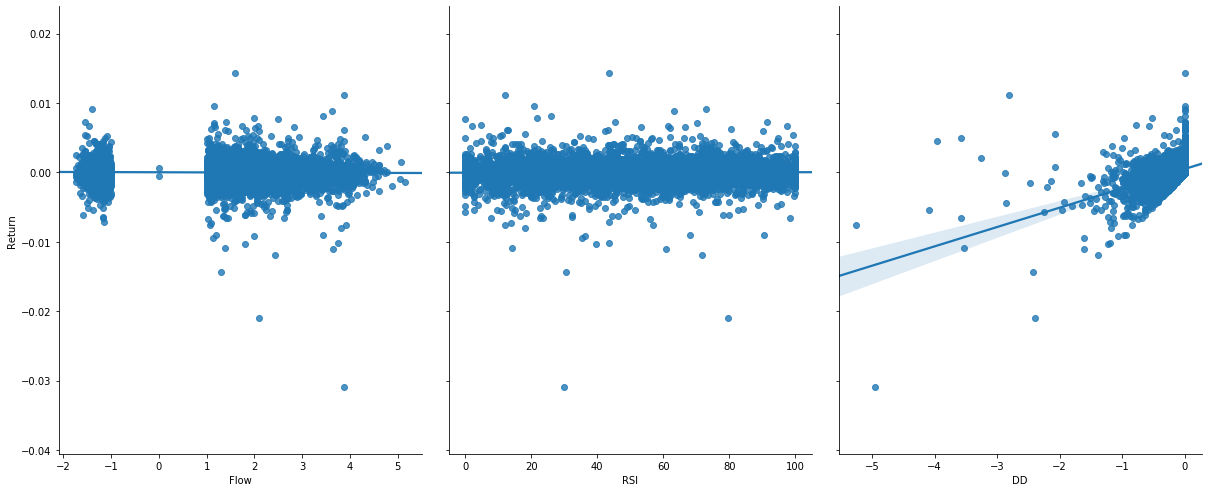

In [438]:
sns.pairplot(df_input, x_vars=['adj_flow','RSI','DD'], y_vars='Return', size=7, aspect=0.8 , kind='reg')
plt.show()

In [ ]:
linreg = LinearRegression()
x_train = df_input.loc['']
model=linreg.fit(X_train, y_train)
print model
print linreg.intercept_
print linreg.coef_

In [ ]:
def calculate_backtest_return(BO_spread,TTE,signal,data): 
    signal.index = signal.index+datetime.timedelta(hours = TTE)
    backtest = pd.concat([data,signal],axis = 1).dropna()
    backtest['Price_pre'] = backtest['Price'].shift()
    # 1. last period's signal, is equal to this period's position
    backtest['signal_pre'] = backtest['signal'].shift()
    # 2. signal in the last 2 period, use this to calculate B/A spread cost
    backtest['signal_pre_pre'] = backtest['signal_pre'].shift()
    backtest.dropna(inplace = True)
    # 3. PnL = change of price * strategy's position during this period - trading cost
    backtest['return'] = ((backtest['Price'] - backtest['Price_pre'])/backtest['Price_pre'])*backtest['signal_pre']-
    np.abs(backtest['signal_pre']-backtest['signal_pre_pre'])*BO_spread/2/backtest['Price_pre']
    
    return backtest['return']